In [1]:
import wandb
import pandas as pd
from utils.utils import plot_confidence_error, expected_calibration_error, calculate_macro_ece, calculate_auroc, calculate_auroc
from utils.utils import extract_texts_and_confidences
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
runs = pd.read_csv("csv/ablation_inference.csv")
ids = list(runs["ID"])
runs

,Name,ID,model,type
0,graceful-galaxy-984,0bl4heg8,gpt-4o,highest
1,denim-flower-966,dm7xia87,gpt-4o-mini,random
2,giddy-spaceship-976,f8bmylzm,Llama-3.3-70B,lowest
3,northern-fire-978,fhcojrwh,Llama-3.3-70B,highest
4,rural-forest-974,i9b1zkbp,DeepSeek-V3,random
5,fresh-paper-980,izp68ibm,Llama-3.3-70B,random
6,youthful-gorge-982,mxeibdce,gpt-4o,lowest
7,worthy-shadow-970,qn3zgr4e,DeepSeek-V3,lowest
8,ruby-mountain-964,un6iizvk,gpt-4o-mini,highest
9,rosy-planet-972,ut4n58mr,DeepSeek-V3,highest


In [2]:
from utils.chat import  Chat
from utils.utils import normalize_text

prompt = (
    "You are given a question, the correct answer, and a guess. "
    "Your task is to determine whether the guess and the correct answer are semantically equivalent.\n"
    "Respond with only “Yes” or “No”. Do not include any other words or phrases.\n\n"
    "<format>\n"
    "Question: {question}\n"
    "Answer: {correct answer}\n"
    "Guess: {best guess}\n"
    "Yes / No\n"
    "</format>\n"
)

def gpt_eval(sample):
    if sample["em"] == 1:
        return 1
    chat = Chat(prompt, model="gpt-4.1-mini")
    chat.add_message(f"Quesiton: {sample["question"]}\nAnswer: {sample["answer"]}\nGuess: {sample["prediction"]}", "user")
    response = chat.response()
    response = normalize_text(response)
    
    if "yes" in response:
        return 1
    elif "no" in response:
        return 0
    else:
        return -1

In [3]:
ids = ["p5stuwl7"]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lukas-hofbauer (hofbauer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.23it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.663
auroc,0.70823
ece,0.22752
f1,0.52121
macro_ece,0.42834


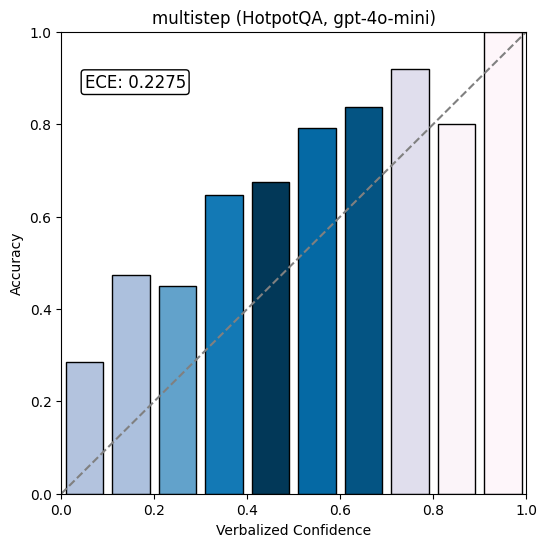

In [4]:
import concurrent.futures
from tqdm import tqdm
from eval import main as evaluate

project_name = "uncertainty-reimplimentation-results"
job_type = "gpt-eval-inference"

for run_id in ids:
    run = wandb.init(
        project=project_name,
        job_type=job_type,
    )
    artifact = run.use_artifact(f"{project_name}/run-{run_id}-table:v0")
    run.config.update(artifact.logged_by().config)
    table = artifact.get("table").get_dataframe()

    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        rows = [row for _, row in table.iterrows()]
        results = list(tqdm(executor.map(gpt_eval, rows), total=len(rows)))
    
    table["gpt_eval"] = results
    
    
    wandb.log({"table": table})
    
    wandb.finish()
    
    results_table = f"run-{run.id}-table"
    args = ["--eval", "gpt_eval", "--job_type", "gpt-eval-eval", "--results_table", results_table]
    evaluate(args)


In [38]:
table[table["em"] != table["gpt_eval"]]

,id,question,answer,type,response,prediction,confidence,f1,em,gpt_eval
4,4ed23bf80bda11eba7f7acde48001122,Where was the performer of song (Last Night) I...,Mount Olive,compositional,"Answer: Mount Olive, Alabama Confidence: 0.9","Mount Olive, Alabama",0.9,0.8,0,1
5,d0a0a43c0bdd11eba7f7acde48001122,Which country Harald Ii Of Denmark's mother is...,Polish,compositional,Answer: Poland Confidence: 0.9,Poland,0.9,0.0,0,1
8,84b56dcc0bd911eba7f7acde48001122,Where was the director of film Little Alvin An...,American,compositional,"Answer: Glendale, California Confidence: 0.9","Glendale, California",0.9,0.0,0,1
25,0788eaa40bde11eba7f7acde48001122,Where was the place of burial of Al-Mu'Tasim's...,Iraq,compositional,Answer: Baghdad Confidence: 0.8,Baghdad,0.8,0.0,0,1
45,0fb43d6a0bdd11eba7f7acde48001122,Who is the spouse of the director of film Mari...,Volker Schlöndorff,compositional,Answer: Margarethe von Trotta's spouse Confide...,Margarethe von Trotta's spouse,0.8,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...
946,1729b4a20bde11eba7f7acde48001122,Which country Bulugan's husband is from?,Yuan dynasty,compositional,Answer: Mongolia Confidence: 0.8,Mongolia,0.8,0.0,0,1
974,7b33f605088411ebbd6dac1f6bf848b6,"Which film has the director died later, Taipei...",Taipei Story,bridge_comparison,Answer: The Ballad Of Cossack Golota Confidenc...,The Ballad Of Cossack Golota,0.8,0.0,0,1
986,1fed480c0bdd11eba7f7acde48001122,Which country Prince Welf Ernst Of Hanover's f...,German,compositional,Answer: Germany Confidence: 0.9,Germany,0.9,0.0,0,1
990,7f5ebde40bdc11eba7f7acde48001122,What is the place of birth of the director of ...,New York,compositional,"Answer: Cobleskill, New York Confidence: 0.8","Cobleskill, New York",0.8,0.8,0,1


top-k


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.428
auroc,0.62292
ece,0.39265
f1,0.40325
macro_ece,0.47853


cot


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.617
auroc,0.74411
ece,0.2409
f1,0.54446
macro_ece,0.39172


direct


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.432
auroc,0.56597
ece,0.39565
f1,0.4073
macro_ece,0.4843


multistep


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.61
auroc,0.73999
ece,0.09218
f1,0.54303
macro_ece,0.39692


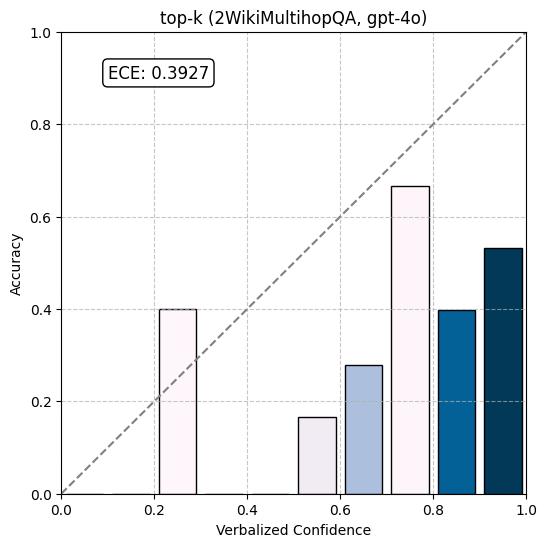

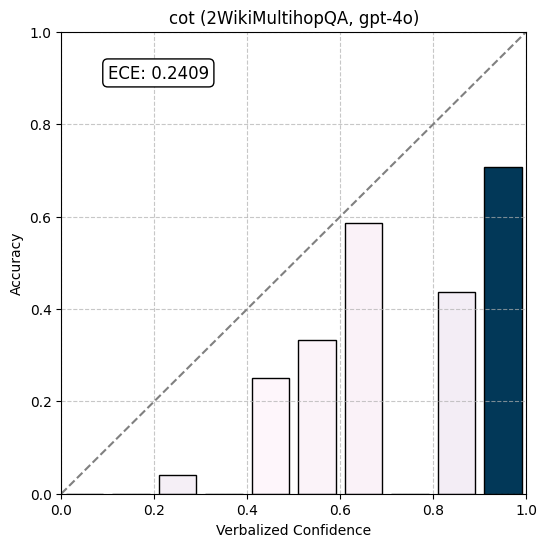

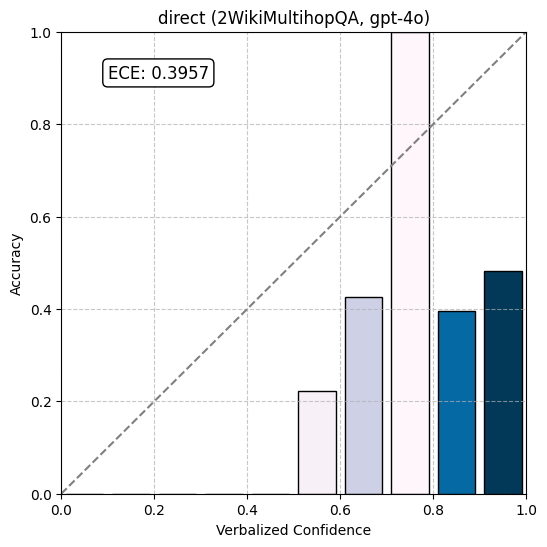

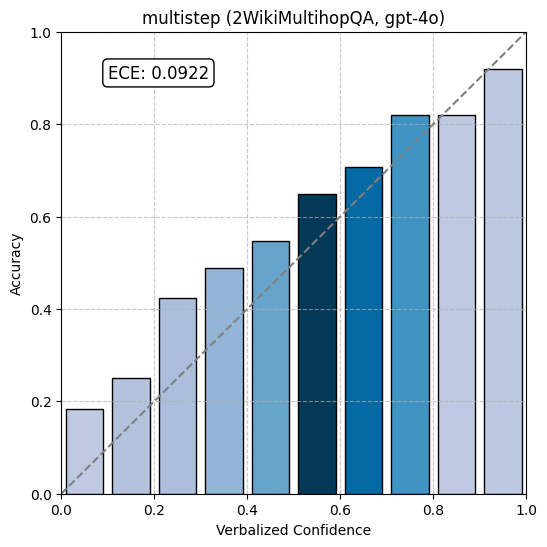

In [49]:
from eval import main as evaluate

ids = {
"top-k": "a5nwxuu5",
"cot": "ao9rzbl6",
"direct": "r8k9lo7u",
"multistep": "ul91s1f1",
}

for key, run_id in ids.items():
    print(key)
    args = ["--eval", "gpt_eval", "--job_type", "gpt-eval-eval", "--results_table", f"run-{run_id}-table"]
    evaluate(args)

In [11]:
import pandas as pd
import wandb
api = wandb.Api()

project_name = "uncertainty-reimplimentation-results"

runs = pd.read_csv("csv/inference.csv")

fns = []
error = []

for _, row in runs.iterrows():
    run_id = row["ID"]
    artifact = api.artifact(f"{project_name}/run-{run_id}-table:v0")
    table: pd.DataFrame = artifact.get("table").get_dataframe()
    
    fp = table[(table["em"] == 1) & (table["gpt_eval"] == 0)]
    fn = table[(table["em"] == 0) & (table["gpt_eval"] == 1)]
    if (len(fp) != 0):
        error.append(fp)
    
    fns.append(len(fn)/len(table))

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo

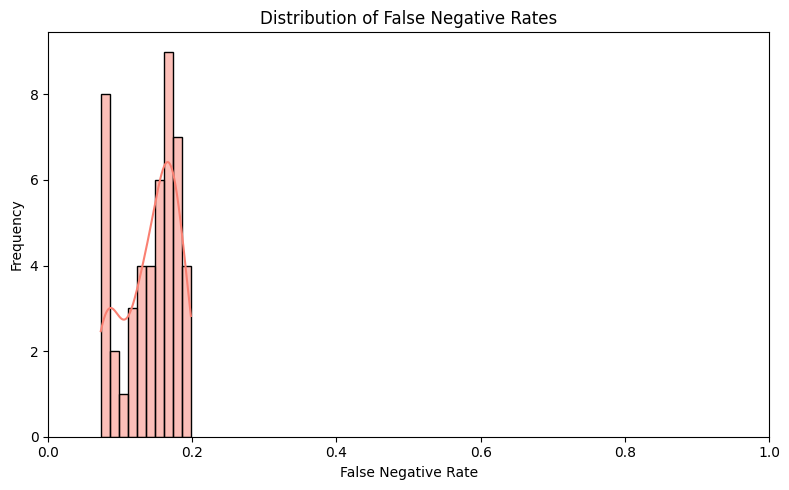

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of false negative rates
plt.figure(figsize=(8, 5))
sns.histplot(fns, bins=10, kde=True, color='salmon', edgecolor='black')

plt.title("Distribution of False Negative Rates")
plt.xlabel("False Negative Rate")
plt.ylabel("Frequency")

plt.xlim(0, 1)  # Since these are proportions, clamp x-axis from 0 to 1
plt.tight_layout()
plt.show()


In [161]:
api = wandb.Api()

tables = []

for prompt, run_id in ids.items():
    artifact = api.artifact(f"{project_name}/run-{run_id}-table:v0")
    table: pd.DataFrame = artifact.get("table").get_dataframe()
    table["prompt"] = prompt
    tables.append(table)

combined_table = pd.concat(tables)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


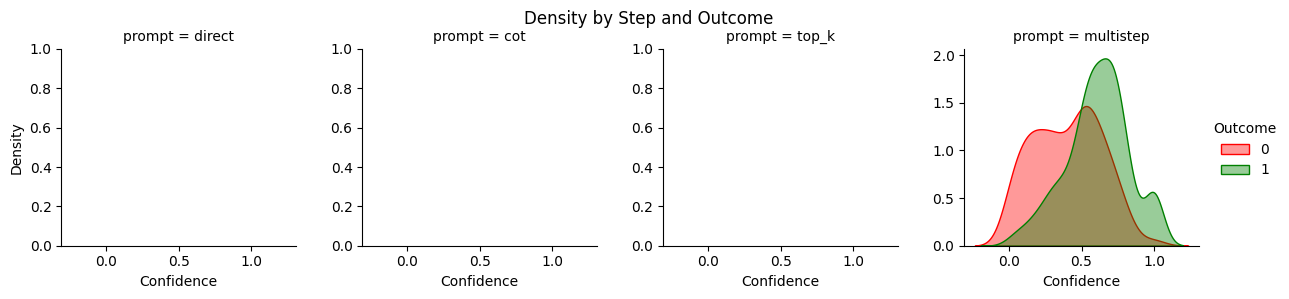

In [27]:
g = sns.FacetGrid(data=table, col="prompt", hue="gpt_eval", sharex=True, sharey=False,
              palette={1:'green',0:'red'}, col_order=["direct", "cot", "top_k", "multistep"])
g.map(sns.kdeplot, "confidence", fill=True, alpha=0.4,bw_adjust=1.1)
g.add_legend(title="Outcome")
g.set_axis_labels("Confidence", "Density")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Density by Step and Outcome')
plt.show()

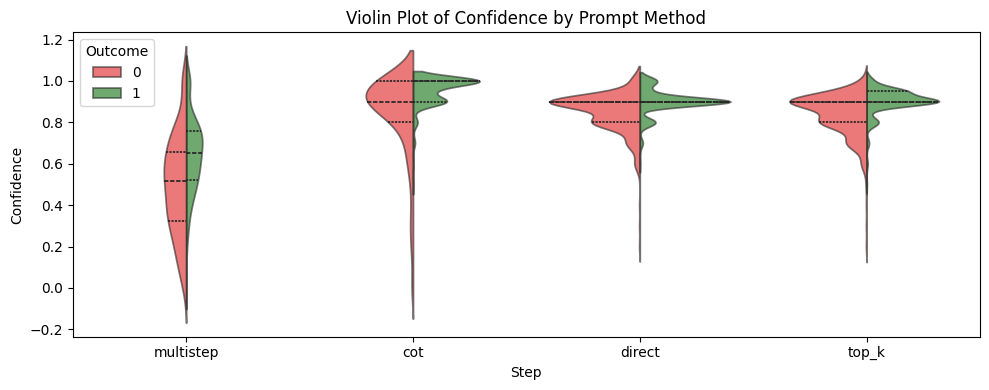

In [245]:
plt.figure(figsize=(10,4))
sns.violinplot(
    x='prompt', y='confidence', hue='em',
    data=combined_table, split=True, inner='quartile', palette={1: "green", 0: "red"}, alpha=0.6, bw_adjust=1.2
)
plt.title('Violin Plot of Confidence by Prompt Method')
plt.ylabel('Confidence')
plt.xlabel('Step')
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

In [262]:
run_id = "5juviva2"
artifact = api.artifact(f"{project_name}/run-{run_id}-table:v0")
table: pd.DataFrame = artifact.get("table").get_dataframe()
table["confs"] = table.apply(lambda x: extract_texts_and_confidences(x["response"])[1], axis=1)
table["num_steps"] = table.apply(lambda x: min(len(x["confs"]) - 1, 5), axis=1)

wandb:   1 of 1 files downloaded.  


In [21]:
table["confs"] = table.apply(lambda x: extract_texts_and_confidences(x["response"])[1], axis=1)
table["num_steps"] = table.apply(lambda x: min(len(x["confs"]) - 1, 5), axis=1)

In [22]:
long = []
for _, row in table.iterrows():
    confs = row["confs"]
    for i, conf in enumerate(confs):
        if i < len(confs) -1 and i < 5:
            long.append({"step" : i, "conf" : conf, "em" : row["em"], "gpt_eval" : row["gpt_eval"], "agg_conf" : row["confidence"]})
        
    long.append({"step" : "answer", "conf" : confs[-1], "em" : row["em"], "gpt_eval" : row["gpt_eval"],"agg_conf" : row["confidence"]})

df_long = pd.DataFrame(long)

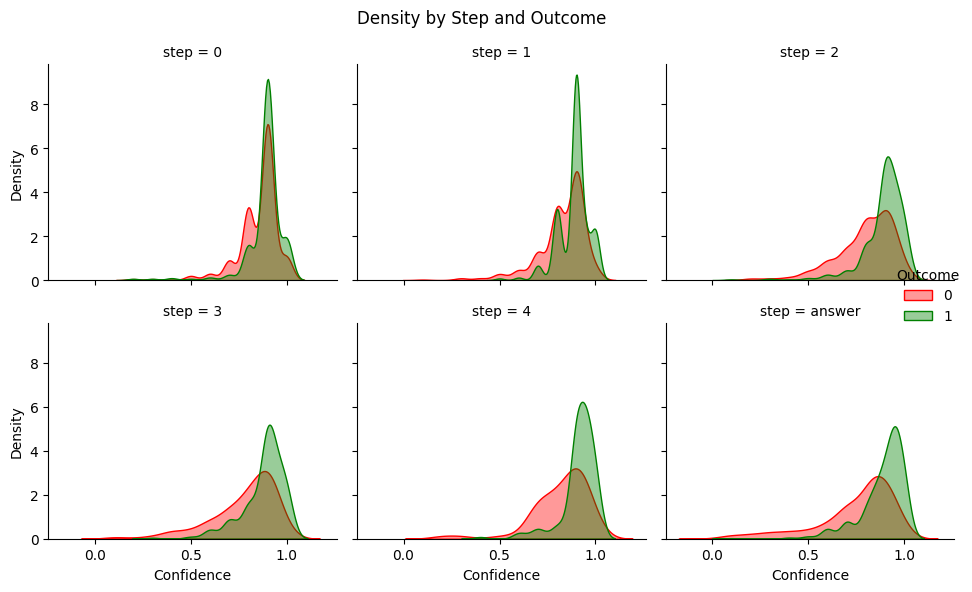

In [29]:
step_order = [0, 1, 2, 3, 4, "answer"]

g = sns.FacetGrid(data=df_long, col="step", hue="em", col_wrap=3, col_order=step_order,
              palette={1:'green',0:'red'})
g.map(sns.kdeplot, "conf", fill=True, alpha=0.4)
g.add_legend(title="Outcome")
g.set_axis_labels("Confidence", "Density")

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Density by Step and Outcome')
plt.tight_layout()
plt.show()

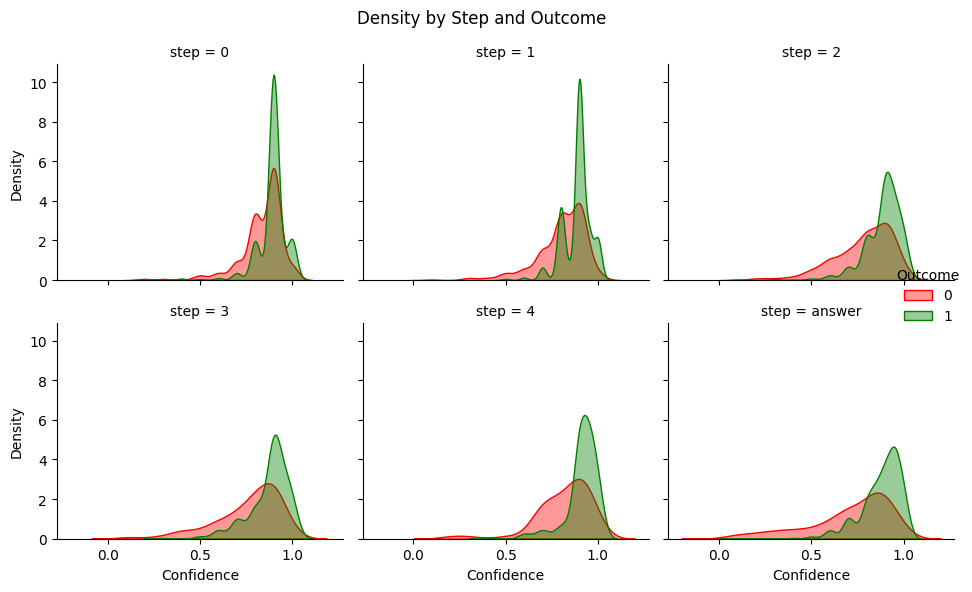

In [28]:
step_order = [0, 1, 2, 3, 4, "answer"]

g = sns.FacetGrid(data=df_long, col="step", hue="gpt_eval", col_wrap=3, col_order=step_order,
              palette={1:'green',0:'red'})
g.map(sns.kdeplot, "conf", fill=True, alpha=0.4)
g.add_legend(title="Outcome")
g.set_axis_labels("Confidence", "Density")

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Density by Step and Outcome')
plt.tight_layout()
plt.show()

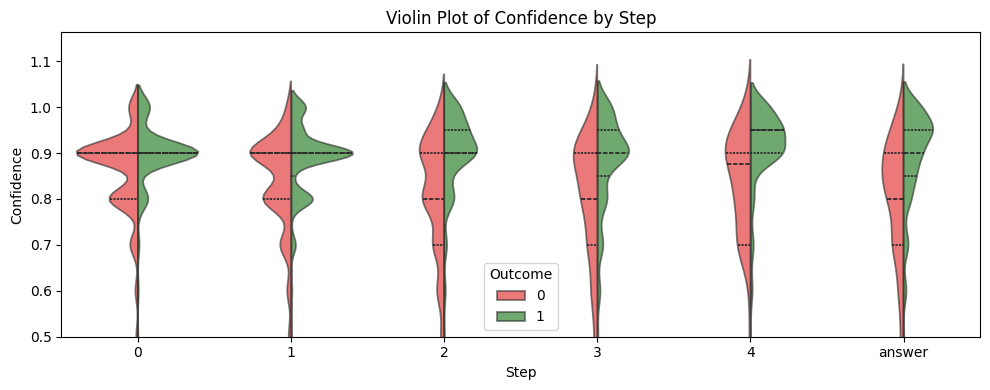

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 2) Plot
plt.figure(figsize=(10,4))
sns.violinplot(
    x="step", y='conf', hue='em',
    data=df_long, split=True, inner='quartile', palette={1: "green", 0: "red"}, alpha=0.6,bw_adjust=0.8, order=step_order,
)
plt.title('Violin Plot of Confidence by Step')
plt.ylabel('Confidence')
plt.xlabel('Step')
plt.legend(title='Outcome')
plt.tight_layout()
plt.ylim(0.5)
plt.show()

(array([206.,   0.,   0., 308.,   0.,   0., 270.,   0.,   0., 216.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

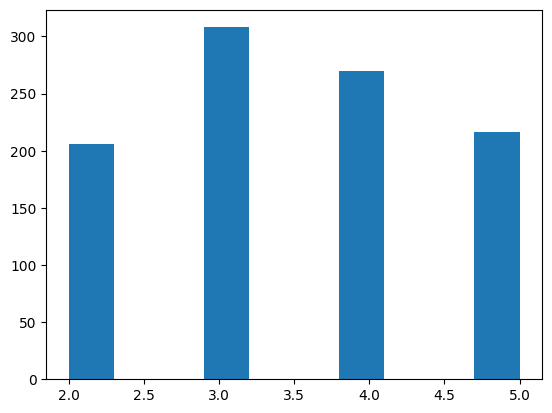

In [30]:
plt.hist(table["num_steps"])

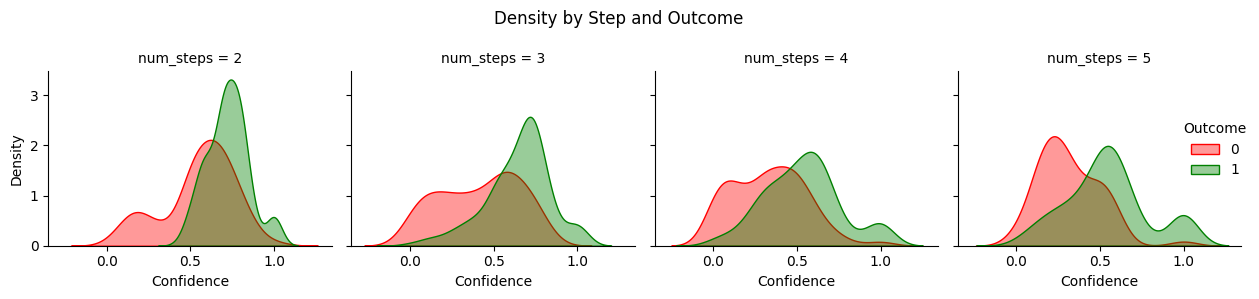

In [31]:
table = table[table["num_steps"] != 1]
g = sns.FacetGrid(data=table, col="num_steps", hue="gpt_eval", col_wrap=4,
              palette={1:'green',0:'red'})
g.map(sns.kdeplot, "confidence", fill=True, alpha=0.4)
g.add_legend(title="Outcome")
g.set_axis_labels("Confidence", "Density")

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Density by Step and Outcome')
plt.tight_layout()
plt.show()

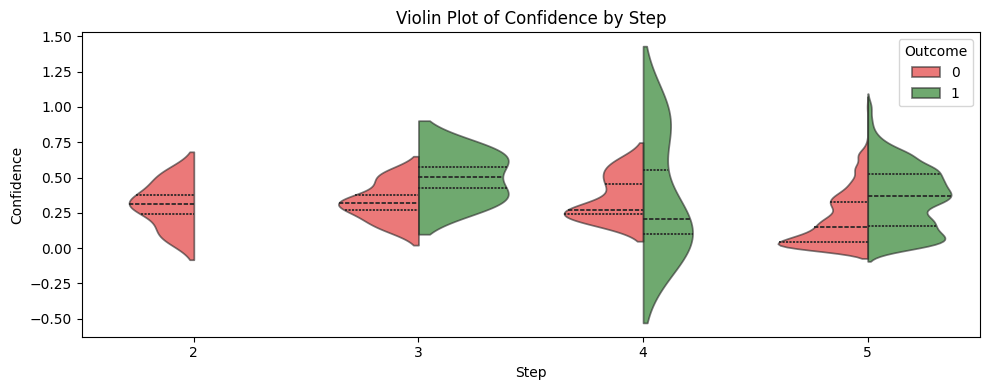

In [268]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 2) Plot
plt.figure(figsize=(10,4))
sns.violinplot(
    x='num_steps', y='confidence', hue='em',
    data=table, split=True, inner='quartile', palette={1: "green", 0: "red"}, alpha=0.6,bw_adjust=0.7
)
plt.title('Violin Plot of Confidence by Step')
plt.ylabel('Confidence')
plt.xlabel('Step')
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()